Matea Pejčinović, 0036462850

Sveučilište u Zagrebu<br>
Fakultet elektrotehnike i računarstva

#Strojno učenje
<a href="http://www.fer.unizg.hr/predmet/su">http://www.fer.unizg.hr/predmet/su</a>

Ak. god. 2014./2015.

#Laboratorijska vježba 3:<br>SVM, neparametarski modeli, vrednovanje klasifikatora i grupiranje

(c) 2014 Jan Šnajder

*Verzija 0.1*<br>
<div style="color:red">NEPOTPUNO</div>

Objavljeno: **11. siječnja 2015.**<br>
Rok za predaju: **22. siječnja 2015.**


# Uvod

Treća se laboratorijska vježba bavi modelom stroja potpornih vektora, neparametarskim modelima, vrednovanjem klasifikatora i grupiranjem. Vježba dakle pokriva sljedeće teme obrađene na predavanjima: *1. Stroj potpornih vektora*, *2. Stabla odluke*, *3.* Učenje na temelju primjera, *4. Vrednovanje klasifikatora*, *5. Grupiranje* i *6. Algoritam maksimizacije očekivanja*. Općenita svrha vježbe jest bolje razumijevanja rada algoritama i njihove matematičke podloge te stjecanje iskustva rada s podatcima.

## Priprema

Prisjetite se rada u SciPy ekosustavu. Poveznice na relevantne resurse navedene su u uvodnome dijelu [prve laboratorijske vježbe](http://nbviewer.ipython.org/url/www.fer.unizg.hr/_download/repository/SU-2014-LAB1.ipynb).

Pročitajte relevante materijale s predavanja i po potrebi konzultirajte dodatnu literaturu:

* **SVM:** Poglavlje 7 iz [skripte](http://www.fer.unizg.hr/_download/repository/StrojnoUcenje.pdf). Ako ste u mogućnosti, pročitajte uvodni dio poglavlja 7 i poglavlja 7.1.1, 7.1.2 i 7.1.3 iz Bishopove knjige te poglavlje 10.9 iz Alpaydinove knjige.
* **Neparametarski modeli:** [Slajdovi](http://www.fer.unizg.hr/_download/repository/SU-4-Stabla-odluke.pdf) i [slajdovi](http://www.fer.unizg.hr/_download/repository/SU-6-UcenjeNaTemeljuPrimjera.pdf) s predavanja. Ako ste u mogućnosti, pročitajte informativno poglavlje 2.5 iz Bishopove knjige te poglavlja 8.1, 8.2 i 9 iz Alpaydinove knjige.
* **Vrednovanje klasifikatora:** [Slajdovi](http://www.fer.unizg.hr/_download/repository/SU-12-VrednovanjeKlasifikatora.pdf) s predavanja. Ako ste u mogućnosti, pročitajte poglavlja 14.1, 14.2 i 14.3 iz Alpaydinove knjige.
* **Grupiranje:** [Slajdovi](http://www.fer.unizg.hr/_download/repository/SU-13-Grupiranje.pdf) i [slajdovi](http://www.fer.unizg.hr/_download/repository/SU-14-AlgoritamMaksimizacijeOcekivanja.pdf) te poglavlje 10 iz [skripte](http://www.fer.unizg.hr/_download/repository/StrojnoUcenje.pdf). Ako ste u mogućnosti, pročitajte poglavlje 9 iz Bishopove knjige i poglavlja 7.3, 7.4, 7.5, 7.7 i 7.8 iz Alpaydinove knjige.

## Upute

Vježba se sastoji od više zadataka grupiranih u tri teme. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg koda te evaluiranja ćelija. 

Molim Vas, osigurajte se da u potpunosti **razumijete** kod koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta preinačiti i ponovno evaluirati Vaš kod. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Stoga se nemojte ograničiti samo na to da riješite zadatak, već slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

# Zadatci

In [1]:
# Učitaj osnovne biblioteke...
import scipy as sp
import sklearn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## A. Stroj potpornih vektora

Kao i u drugoj vježbi, definirat ćemo malen skup podataka `seven` kako bismo na takvom manjem skupu lakše analizirali ponašanje SVM-a:

In [2]:
seven_X = sp.array([[2,1],[2,3],[1,2],[3,2],[5,2],[5,4],[6,3]])
seven_y = sp.array([1,1,1,1,-1,-1,-1])

In [3]:
b = sp.array([[0,0],[2,4],[4,2],[6,4],[6,8],[8,8]])
i = sp.array([-1,-1,-1,1,1,1])

Funkcija za iscrtavanje skupa podataka i granice između klasa (kao i u drugoj vježbi):

In [4]:
def plot_problem(X, y, h=None, surfaces=True, naziv="") :
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision boundaries (surfaces=False) or decision surfaces (surfaces=True)
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.02  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if shape(Z_test) == () :
                Z = sp.array(map(h,XX))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = sp.array(map(h,XX))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        if surfaces :
            plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        else :
            plt.contour(xx, yy, Z)
    # Plot the dataset
    scatter(X[:,0],X[:,1],c=y, cmap=plt.cm.Paired,marker='o',s=50);
    title(naziv)

In [5]:
def plotPRoblem(X, y, model, h=None, surfaces=True, naziv="") :
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision boundaries (surfaces=False) or decision surfaces (surfaces=True)
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.02  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if shape(Z_test) == () :
                # h returns a scalar when applied to a matrix; map explicitly
                Z = sp.array(map(h,XX))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = sp.array(map(h,XX))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        if surfaces :
            plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        else :
            plt.contour(xx, yy, Z)
    XX, YY = np.mgrid[x_min:x_max:800j, y_min:y_max:800j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])
    scatter(X[:,0],X[:,1],c=y, cmap=plt.cm.Paired,marker='o',s=50);
    title(naziv)
    plt.show()

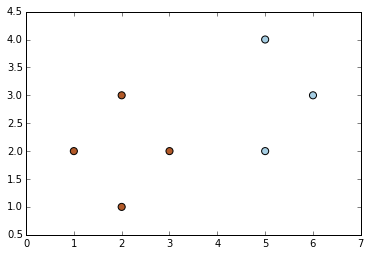

In [6]:
plot_problem(seven_X, seven_y)

### A.1

Upoznajte se sa klasom [`svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), koja ustvari implementira sučelje prema implementaciji [`libsvm`](http://www.csie.ntu.edu.tw/~cjlin/libsvm/). 

Primijenite model `SVC` s linearnom jezgrenom funkcijom (tj. bez preslikavanja primjera u prostor značajki) na skup podataka `seven`. Prikažite dobivenu granicu između klasa, ispišite koeficijente $w_0$ i $\mathbf{w}$ te izračunajte širinu margine. Ispišite dualne koeficijente i potporne vektore.

Prisjetite se da $h(\mathbf{x})=\tilde{\mathbf{w}}^\intercal\tilde{\mathbf{x}}$ odgovara udaljenosti primjera $\mathbf{x}$ od granice definirane sa $h(\mathbf{x})=0$. Provjerite da je upravo to vrijednost koju izračunava funkcija `svm.decision_function`. Preinačite funkciju `plot_problem` tako da, uz granicu između klasa, prikazuje i marginu.

**Q:** Koliko iznosi širina margine i zašto?

**Q:** Koji su primjeri potporni vektori i zašto?

Širina margine je 2.00117221832 što je najveća udaljenost između dva primjera koja pripadaju različitim klasama.
Potporni vektori su primjeri [3, 2], [5, 2], [5, 4] jer se upravo za njih dobije maksimalna margina.

In [7]:
def plot_Problem(X, y, model, h=None, surfaces=True, naziv="") :
    axes = plt.gca()
    axes.set_xlim([0,7])
    axes.set_ylim([0,5])
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision boundaries (surfaces=False) or decision surfaces (surfaces=True)
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.02  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if shape(Z_test) == () :
                # h returns a scalar when applied to a matrix; map explicitly
                Z = sp.array(map(h,XX))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = sp.array(map(h,XX))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        if surfaces :
            plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        else :
            plt.contour(xx, yy, Z)
    # Plot the dataset
    a = -model.coef_[0][0] / model.coef_[0][1]
    xx1 = np.linspace(0, 6)
    b = clf.support_vectors_[0]
    yy_down = a * xx1 + (clf.support_vectors_[0][1] - a * clf.support_vectors_[0][0])
    yy_up = a * xx1 + (clf.support_vectors_[-1][1] - a * clf.support_vectors_[-1][0])
    

    # plot the line, the points, and the nearest vectors to the plane
    plt.plot(xx1, yy_down, 'k--')
    plt.plot(xx1, yy_up, 'k--')
    scatter(X[:,0],X[:,1],c=y, cmap=plt.cm.Paired,marker='o',s=50);
    title(naziv)

In [8]:
def ploTProblem(X, y, h=None, surfaces=True, model=None) :
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision boundaries (surfaces=False) or decision surfaces (surfaces=True)
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.02  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if shape(Z_test) == () :
                # h returns a scalar when applied to a matrix; map explicitly
                Z = sp.array(map(h,XX))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = sp.array(map(h,XX))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        if surfaces :
            plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        else :
            plt.contour(xx, yy, Z)
            
        if model:
            w = model.coef_[0]
            
            yy_down, yy_up = 0, 0
            xx = np.linspace(x_min, x_max)
            margin = 1 / np.sqrt(np.sum(model.coef_ ** 2))
            if w[1] == 0:
                xx = (-(model.intercept_[0]) / w[0])
                yy = np.linspace(y_min, y_max)
                xx_down = xx - margin
                xx_up = xx + margin
                a = np.empty(shape(yy)[0])
                b = np.empty(shape(yy)[0])
                print("xxdown ", xx_down)
                print("xxup ", xx_up)
                a.fill(xx_down)
                b.fill(xx_up)
                plt.plot(a, yy, 'k--')
                plt.plot(b, yy, 'k--')
            else:
                a = -w[0] / w[1]
                yy = a * xx - (model.intercept_[0]) / w[1]
                yy_down = yy + a * margin
                print("yydown ", yy_down)
                yy_up = yy - a * margin
                print("yyup ", yy_up)
                xx = np.linspace(x_min, x_max)
                plt.plot(xx, yy_down, 'k--')
                plt.plot(xx, yy_up, 'k--')
            
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
    # Plot the dataset
    scatter(X[:,0],X[:,1],c=y, cmap=plt.cm.Paired,marker='o',s=50);

Tezine iznose:
[ 3.99951172]
[ -9.99707031e-01  -2.92968750e-04]

Dobiveno s hx:
[ 1.99980469  1.99921875  2.99921875  0.99980469 -0.99960938 -1.00019531
 -1.99960938]
Dobiveno s decision_function:
[[ 1.99980469]
 [ 1.99921875]
 [ 2.99921875]
 [ 0.99980469]
 [-0.99960937]
 [-1.00019531]
 [-1.99960938]]
Sirina margine:  2.00117221832
Potporni vektori su: 
[[ 5.  2.]
 [ 5.  4.]
 [ 3.  2.]]


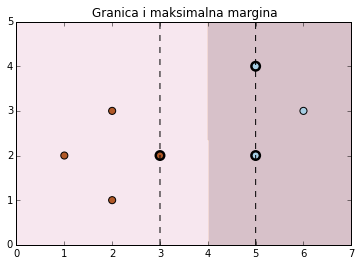

In [8]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(seven_X, seven_y)

print ("Tezine iznose:")
print (clf.intercept_)
print (clf.coef_[0])
print()
hx = np.dot(seven_X, clf.coef_[0]) + clf.intercept_
df = clf.decision_function(seven_X)
print("Dobiveno s hx:")
print(hx)
print ("Dobiveno s decision_function:")
print (df)

print ("Sirina margine: ", 2 / np.dot(clf.coef_[0].T, clf.coef_[0]))

print ("Potporni vektori su: ")
print (clf.support_vectors_)

izlaz = []
for i in range(len(seven_X)):
    for j in clf.support_vectors_:
        if (float(seven_X[i][0]) == j[0]) and (float(seven_X[i][1]) == j[1]):
            izlaz.append(seven_y[i])
izlaz = sp.array(izlaz)
plot_Problem(seven_X, seven_y, clf, lambda x : clf.predict(x), naziv = "Granica i maksimalna margina")
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='none', linewidths=2, zorder=10)

Tezine iznose:
[-4.]
[ 0.5  0.5]

Dobiveno s hx:
[-4. -1. -1.  1.  3.  4.]
Dobiveno s decision_function:
[[-4.]
 [-1.]
 [-1.]
 [ 1.]
 [ 3.]
 [ 4.]]
Sirina margine:  4.0
Potporni vektori su: 
[[ 4.  2.]
 [ 6.  4.]]


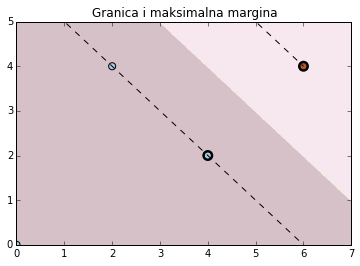

In [9]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(b, i)

print ("Tezine iznose:")
print (clf.intercept_)
print (clf.coef_[0])
print()
hx = np.dot(b, clf.coef_[0]) + clf.intercept_
df = clf.decision_function(b)
print("Dobiveno s hx:")
print(hx)
print ("Dobiveno s decision_function:")
print (df)

print ("Sirina margine: ", 2 / np.dot(clf.coef_[0].T, clf.coef_[0]))

print ("Potporni vektori su: ")
print (clf.support_vectors_)

izlaz = []
for l in range(len(b)):
    for j in clf.support_vectors_:
        if (float(b[l][0]) == j[0]) and (float(b[l][1]) == j[1]):
            izlaz.append(i[l])
izlaz = sp.array(izlaz)
plot_Problem(b, i, clf, lambda x : clf.predict(x), naziv = "Granica i maksimalna margina")
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='none', linewidths=2, zorder=10)

Navedeni potporni vektori su primjeri koji si najbliže margini. To su tri primjera koja se mogu koristiti za određivanje margine.

### A.2 (bonus)

Izraz (7.7) u skripti opisuje vezu između predikcije modela u primarnoj i dualnoj formulaciji problema maksimalne margine:

\begin{equation}
h(\mathbf{x})=\mathbf{w}^\intercal\mathbf{x}+w_0 = 
\sum_{i=1}^N \alpha_i y^{(i)}\mathbf{x}^\intercal\mathbf{x} + w_0
\end{equation}

Definirajte funkcije `h_primal(x,w,w0)` i `h_dual(x,X,y,dc,sv)` koje implementiraju predikciju u primarnoj odnosno dualnoj formulaciji problema, pri čemu su `(w,w0)` težine, `(X,y)` označen skup primjera, `dc` su dualni koeficijenti, `sv` su indeksi potpornih vektora (koji su pohranjeni u `svc.support_`), a `x` je primjer za koji se radi predikcija. Također implementirajte funkciju `w0(X,y,dc,sv)` koja izračunava težinu `w_0` pomoću izraza (7.8) iz skripte. Uvjerite se da ove dvije funkcije na skupu `seven` funkcije daju identične predikcije i da su one identične onima koje daje ugrađena funkcija `svc.decision_function`.

**NB:** Dualni koeficijenti koje vraća `svc.dual_coef_[0]` ne odgovaraju Lagrangeovim multiplikatorima $\alpha_i$ već vrijednostima $-\alpha_i y^{(i)}$.

**Q:** Jedan od triju potpornih vektora na skupu `seven` je suvišan. Koji? Uvjerite se da `h_dual` daje identične predikcije i bez tog vektora.

Višak je onaj s indeksom 5.

In [11]:
'''
def h_dual(x, X, y, dc, sv, koef):
    alfa = np.dot(np.dot(X, X.T), y)
    #print(alfa)
    scaler1 = StandardScaler().fit(alfa)
    alfaS = scaler1.transform(alfa) 
    l2Tezine = 0.5 * np.dot(koef.T, koef)
    rez = []
    for i in range(len(seven_X)):
        el = alfaS[i]
        for j in range(len(seven_X)):
            el = el - 0.5 * alfaS[i] * alfaS[j] * y[i] * y[j] * np.dot(seven_X[i], seven_X[j].T)
        rez.append(el)
    scaler1 = StandardScaler().fit(rez)
    rezS = scaler1.transform(rez)
    print (rezS)
x = [4, 1]
#x = [1, 1]
clfDP = SVC(kernel = 'linear')
clfDP.fit(seven_X, seven_y)
h_dual(x, seven_X, seven_y, clfDP.dual_coef_[0], clfDP.support_, clfDP.coef_[0])
print (clfDP.decision_function(seven_X))
'''

"\ndef h_dual(x, X, y, dc, sv, koef):\n    alfa = np.dot(np.dot(X, X.T), y)\n    #print(alfa)\n    scaler1 = StandardScaler().fit(alfa)\n    alfaS = scaler1.transform(alfa) \n    l2Tezine = 0.5 * np.dot(koef.T, koef)\n    rez = []\n    for i in range(len(seven_X)):\n        el = alfaS[i]\n        for j in range(len(seven_X)):\n            el = el - 0.5 * alfaS[i] * alfaS[j] * y[i] * y[j] * np.dot(seven_X[i], seven_X[j].T)\n        rez.append(el)\n    scaler1 = StandardScaler().fit(rez)\n    rezS = scaler1.transform(rez)\n    print (rezS)\nx = [4, 1]\n#x = [1, 1]\nclfDP = SVC(kernel = 'linear')\nclfDP.fit(seven_X, seven_y)\nh_dual(x, seven_X, seven_y, clfDP.dual_coef_[0], clfDP.support_, clfDP.coef_[0])\nprint (clfDP.decision_function(seven_X))\n"

In [9]:
def h_primal(x, w, w0):
    return (np.dot(w, x.T) + w0)

In [10]:
def h_dual(x, X, y, dc, sv, koef):
    #print (dc[0])
    #print(dc[1])
    #print(dc[2])
    hx = []
    skup = []
    izlaz = []
    for el in sv:
        skup.append(X[el])
        izlaz.append(y[el])
    skup = sp.array(skup)
    izlaz = sp.array(izlaz)
    hx = 0
    for el in range(len(skup)):
        hx = hx + ( - dc[el]) * np.dot(skup[el], x)
    return hx + koef

In [11]:
print ("Rezultat koji daje decizijska funkcija")
print ("---------------------------------------")
rez = []
fd1 = clf.decision_function(seven_X)
for el in fd1:
    for i in range(1):
        rez.append(el[i])
print (sp.array(rez))

print ("Rezultat koji se dobije primalom")
print ("---------------------------------------")
rezPrimal = []
for el in seven_X:
    rezPrimal.append(h_primal(el, clf.coef_[0], clf.intercept_[0]))
print (sp.array(rezPrimal))

print ("Rezultat koji se dobije dualom")
print ("---------------------------------------")
rezDual = []
for el in seven_X:
    rezDual.append(h_dual(el, seven_X, seven_y, clf.dual_coef_[0], clf.support_, clf.intercept_[0]))
print(sp.array(rezDual))

Rezultat koji daje decizijska funkcija
---------------------------------------
[ 1.99980469  1.99921875  2.99921875  0.99980469 -0.99960937 -1.00019531
 -1.99960938]
Rezultat koji se dobije primalom
---------------------------------------
[ 1.99980469  1.99921875  2.99921875  0.99980469 -0.99960938 -1.00019531
 -1.99960938]
Rezultat koji se dobije dualom
---------------------------------------
[ 1.99980469  1.99921875  2.99921875  0.99980469 -0.99960937 -1.00019531
 -1.99960938]


In [12]:
def h_dual(x, X, y, dc, koef):
    hx = []
    skup = []
    izlaz = []
    dc1 = []
    dc1.append(dc[0])
    dc1.append(dc[2])
    sv = [4, 3]
    for el in sv:
        skup.append(X[el])
        izlaz.append(y[el])
    skup = sp.array(skup)
    izlaz = sp.array(izlaz)
    hx = 0
    for el in range(len(skup)):
        hx = hx + ( - dc1[el]) * np.dot(skup[el], x)
    return hx + koef
    
rez = []
for el in seven_X:
    rez.append(h_dual(el, seven_X, seven_y, clf.dual_coef_[0], clf.intercept_[0]))
print(sp.array(rez))

[ 2.00185547  2.00244141  3.00112305  1.00317383 -0.99477539 -0.99418945
 -1.99345703]


In [13]:
def w0(X, y, dc, sv):
    hx = []
    skup = []
    izlaz = []
    for el in sv:
        skup.append(X[el])
        izlaz.append(y[el])
    skup = sp.array(skup)
    izlaz = sp.array(izlaz)
    hx = 0
    for el in range(len(skup)):
        pom = 0
        for e in range(len(skup)):
            pom = pom + ( dc[e]) * np.dot(skup[el], skup[e])
        hx = hx + pom +  izlaz[el]
    return (hx/len(sv))
    
print("Rezultat dobiven pomocu clf.intercept_: ",clf.intercept_[0])
print ("Rezultat dobiven pomocu funkcije w0: ",w0(seven_X, seven_y, clf.dual_coef_[0], clf.support_))

Rezultat dobiven pomocu clf.intercept_:  3.99951171875
Rezultat dobiven pomocu funkcije w0:  3.99951171875


### A.3

Trenirajte na skupu `seven` tri linearna modela -- perceptron, logističku regresiju i linearni SVM -- te prikažite dobivenu granicu između klasa za sva tri modela. 

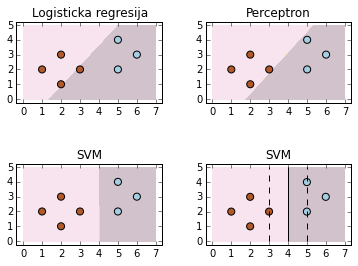

In [14]:
from sklearn.linear_model import Perceptron, LogisticRegression

subplots_adjust(wspace = 0.3, hspace=.75)

clfLR = LogisticRegression()
clfLR.fit (seven_X, seven_y)
subplot(2, 2, 1)
plot_problem(seven_X, seven_y, lambda x : clfLR.predict(x) > 0, naziv = "Logisticka regresija")

clfP = Perceptron(penalty=None, alpha=0.0001, fit_intercept=True, n_iter=17, shuffle = True, verbose=0, eta0=1.0, n_jobs=1, random_state=0, class_weight=None, warm_start=False)
clfP.fit (seven_X, seven_y)
subplot(2, 2, 2)
plot_problem(seven_X, seven_y,  lambda seven_X : clfP.predict(seven_X) >= 0, surfaces=True, naziv = "Perceptron")

subplot(2, 2, 3)
plot_problem(seven_X, seven_y,  lambda seven_X : clf.predict(seven_X) >= 0, surfaces=True, naziv = "SVM")
subplot(2, 2, 4)
plotPRoblem(seven_X, seven_y, clf,  lambda seven_X : clf.predict(seven_X) >= 0, surfaces=True, naziv = "SVM")


Zatim ponovite treniranje na skupu s dodatnim, osmim primjerom koji odskače te prikažite opet dobivene granice između klasa za sva tri modela.

In [15]:
X = sp.append(seven_X,[[12,8]],axis=0)
y = sp.append(seven_y,-1)

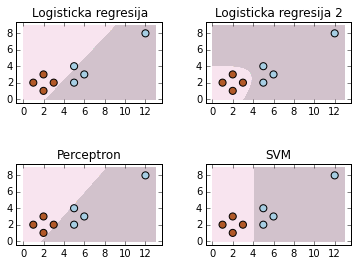

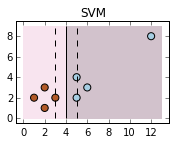

In [16]:
from sklearn.preprocessing import PolynomialFeatures
subplots_adjust(wspace = 0.3, hspace=.75)

clfLR1 = sklearn.linear_model.LinearRegression()
clfLR1.fit (X, y)
subplot(2, 2, 1)
plot_problem(X, y, lambda x : clfLR1.predict(x) > 0, naziv = "Logisticka regresija")

poly = PolynomialFeatures(2)
prikaz = poly.fit_transform(X)
clfLR2 = sklearn.linear_model.LinearRegression()
clfLR2.fit (prikaz, y)
subplot(2, 2, 2)
plot_problem(X, y, lambda x : clfLR2.predict(poly.fit_transform(x)) > 0, naziv = "Logisticka regresija 2")


clfP1 = Perceptron(penalty=None, alpha=0.0001, fit_intercept=True, n_iter=17, shuffle = True, verbose=0, eta0=1.0, n_jobs=1, random_state=0, class_weight=None, warm_start=False)
clfP1.fit (X, y)
subplot(2, 2, 3)
plot_problem(X, y,  lambda x : clfP.predict(x) >= 0, surfaces=True, naziv = "Perceptron")

subplot(2, 2, 4)
clf1 = SVC(kernel = 'linear')
clf1.fit(X, y)
plot_problem(X, y,  lambda x : clf1.predict(x) >= 0, surfaces=True, naziv = "SVM")
show()
subplot(2, 2, 1)
plotPRoblem(X, y, clf1,  lambda x : clf.predict(x) >= 0, surfaces=True, naziv = "SVM")

Definirajte funkciju `hinge(model,x,y)` koja izračunava gubitak zglobnice modela SVM na primjeru `x`. Izračunajte prosječni gubitak SVM-a na skupovima `seven` i skupu s dodatnim primjerom. Uvjerite se da je rezultat identičan onome koji biste dobili primjenom ugrađene funkcije [`metrics.hinge_loss`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html).

In [17]:
def hinge(model, x, y):
    hx = model.decision_function(x)
    m = 0
    for i in range(len(y)):
        k = 1 - np.dot(y[i], hx[i])
        if k > 0:
            m = m + k
    return m/(len(x))

In [18]:
from sklearn.metrics import hinge_loss
from sklearn.svm import SVC
print ("Rezultati za nelinearni SVM")
print("-----------------------------------------------")
est1 = SVC()
est1.fit(seven_X, seven_y)
print (" *Na skupu seven: ",hinge_loss(seven_y, est1.decision_function(seven_X)))

est2 = SVC()
est2.fit(X, y)
print (" *Na prosirenom skupu seven: ",hinge_loss(y, est2.decision_function(X)))

print (" *Hinge na skupu seven: ", hinge(est1, seven_X, seven_y))
print (" *Hinge na prosirenom skupu seven: ",hinge(est2, X, y))

Rezultati za nelinearni SVM
-----------------------------------------------
 *Na skupu seven:  5.50240537484e-06
 *Na prosirenom skupu seven:  0.000123556420572
 *Hinge na skupu seven:  [  5.50240537e-06]
 *Hinge na prosirenom skupu seven:  [ 0.00012356]


In [19]:
from sklearn.metrics import hinge_loss
from sklearn.svm import SVC
print ("Rezultati za linearni SVM")
print("-----------------------------------------------")
est1 = SVC(kernel = 'linear')
est1.fit(seven_X, seven_y)
print (" *Na skupu seven: ",hinge_loss(seven_y, est1.decision_function(seven_X)))

est2 = SVC(kernel = 'linear')
est2.fit(X, y)
print (" *Na prosirenom skupu seven: ",hinge_loss(y, est2.decision_function(X)))

print (" *Hinge na skupu seven: ", hinge(est1, seven_X, seven_y))
print (" *Hinge na prosirenom skupu seven: ",hinge(est2, X, y))

Rezultati za linearni SVM
-----------------------------------------------
 *Na skupu seven:  8.37053571429e-05
 *Na prosirenom skupu seven:  0.0
 *Hinge na skupu seven:  [  8.37053571e-05]
 *Hinge na prosirenom skupu seven:  0.0


**Q:** Jesu li rezultati očekivani? Obrazložite.

Rezultati jesu očekivani jer u proširenom skupu imamo primjer koji je duboko u svojoj klasi te je očito da njega neće model kažnjavati.

### A.4

Razmotrimo sljedeće dvije varijante problema `seven`, svaka s osam primjera:

In [20]:
X1, y1 = sp.append(seven_X, [[3,3]], axis=0), sp.append(seven_y, -1)
X2, y2 = sp.append(seven_X, [[2,2]], axis=0), sp.append(seven_y, -1)

Na svakom od ova dva skupa trenirajte linearni SVM, mijenjajući parametar $C$ koji određuje složenost modela, $C\in\{10^{-2},1,10^2\}$. Za svaki naučeni model prikažite granicu između klasa, ispišite širinu margine, potporne vektore te prosječan gubitak zglobnice.

**Q:** Komentirajte dobivene rezultate.

**Q:** Zašto šira margina rezultira većim prosječnim gubitkom?

Faktor c utječe na nagib granice; šira margina znači da će određeni broj primjera moći upasti u područje margine, a to pak znači da će i oni biti kažnjavani, čak i ako su s prave strane granice.  

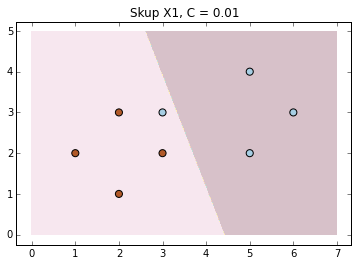

Sirina margine:  17.0871531543
Potporni vektori su: 
[[ 5.  2.]
 [ 5.  4.]
 [ 6.  3.]
 [ 3.  3.]
 [ 2.  1.]
 [ 2.  3.]
 [ 1.  2.]
 [ 3.  2.]]
Prosjecan gubitak zglobnice:  [ 0.82875]


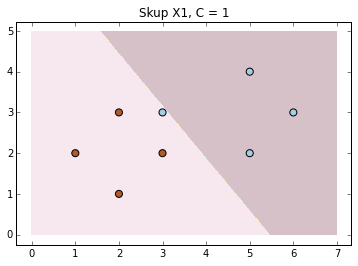

Sirina margine:  1.75411603861
Potporni vektori su: 
[[ 5.  2.]
 [ 3.  3.]
 [ 2.  3.]
 [ 3.  2.]]
Prosjecan gubitak zglobnice:  [ 0.1625]


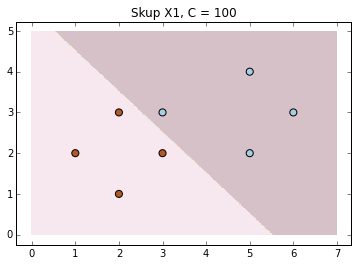

Sirina margine:  0.707106781187
Potporni vektori su: 
[[ 3.  3.]
 [ 2.  3.]
 [ 3.  2.]]
Prosjecan gubitak zglobnice:  [  6.66133815e-16]


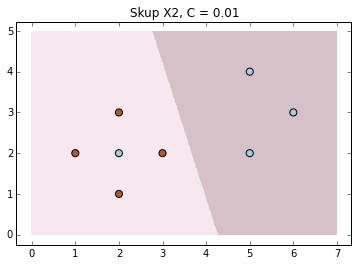

Sirina margine:  19.1565257044
Potporni vektori su: 
[[ 5.  2.]
 [ 5.  4.]
 [ 6.  3.]
 [ 2.  2.]
 [ 2.  1.]
 [ 2.  3.]
 [ 1.  2.]
 [ 3.  2.]]
Prosjecan gubitak zglobnice:  [ 0.86375]


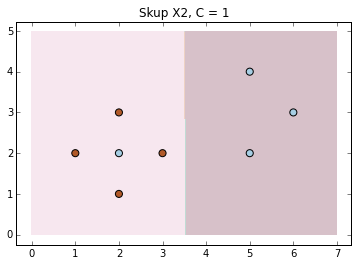

Sirina margine:  3.00074934316
Potporni vektori su: 
[[ 5.  2.]
 [ 5.  4.]
 [ 2.  2.]
 [ 2.  3.]
 [ 3.  2.]]
Prosjecan gubitak zglobnice:  [ 0.3334375]


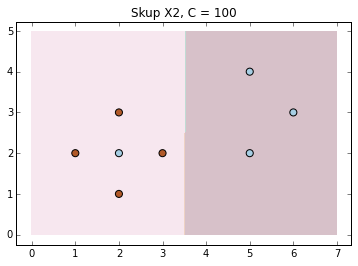

Sirina margine:  2.99972150961
Potporni vektori su: 
[[ 5.  2.]
 [ 5.  4.]
 [ 2.  2.]
 [ 2.  1.]
 [ 2.  3.]
 [ 3.  2.]]
Prosjecan gubitak zglobnice:  [ 0.33338747]


In [22]:
c = [0.01, 1, 100]

for i in range(len(c)):
    clfLSVM = SVC(C = c[i], kernel='linear')
    clfLSVM.fit(X1, y1)
    plot_problem(X1, y1, lambda x : clfLSVM.predict(x))
    title("Skup X1, C = " + str(c[i]))
    show()
    print ("Sirina margine: ", 2 / linalg.norm(clfLSVM.coef_[0]))
    print ("Potporni vektori su: ")
    print (clfLSVM.support_vectors_)
    print ("Prosjecan gubitak zglobnice: ",hinge(clfLSVM.fit(X1, y1), X1, y1))

for i in range(len(c)):
    clfLSVM = SVC(C = c[i], kernel='linear')
    clfLSVM.fit(X2, y2)
    plot_problem(X2, y2, lambda x : clfLSVM.predict(x))
    title("Skup X2, C = " + str(c[i]))
    show()
    print ("Sirina margine: ", 2 / linalg.norm(clfLSVM.coef_[0]))
    print ("Potporni vektori su: ")
    print (clfLSVM.support_vectors_)
    print ("Prosjecan gubitak zglobnice: ",hinge(clfLSVM.fit(X2, y2), X2, y2))

### A.5

Trenirajte linearni SVM na skupu `seven` te skupovima `(X1,y1)` i `(X2,y2)` iz prethodnoga zadatka, mijenjajući parametar $C$ po vrijednostima $C\in\{2^{-5},2^{-4},\dots,2^2,2^3\}$. Prikažite krivulju pogreške zglobnice i L2-normu vektora težina u ovisnosti o parametru $C$ na sva tri skupa podataka (tri grafikona).

**Q:** Koji dio grafikona odgovara prenaučenosti a koji podnaučenosti modela?

Faktor c sluzi za reguliranje pogreške; vidimo da za veći c dobivamo veću vrijednost L2-norme vektora, odnosno pada pogreška zglobnice. To pak znači da s većim c idemo u područje prenaučenosti.

In [25]:
e = linspace(-5, 3, 9)
c = []
for i in e:
    c.append(math.pow(2, float(i)))

In [26]:
def L2norma (w):
    return np.dot(w.T, w)

In [27]:
def L2norm (w):
    return linalg.norm(w)

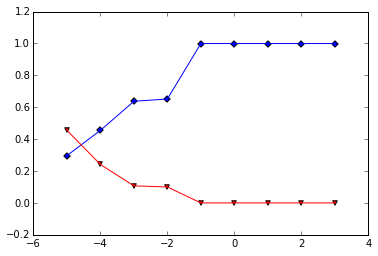

In [28]:
pogZ = []
l2 = []
for i in range(len(c)):
    clfLSVM = SVC(C = c[i], kernel='linear')
    clfLSVM.fit(seven_X, seven_y)
    pogZ.append(hinge(clfLSVM.fit(seven_X, seven_y), seven_X, seven_y))
    l2.append(L2norm(clfLSVM.coef_))
matplotlib.pyplot.scatter(e, l2, s=20, c=u'b', marker=u'D')
matplotlib.pyplot.scatter(e, pogZ, s=20, c=u'r', marker=u'v')
plot(e, l2, 'b', e, pogZ, 'r')

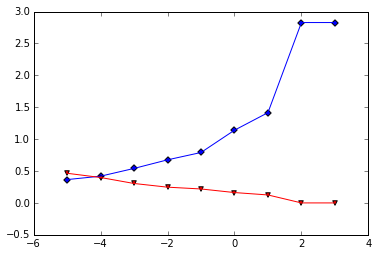

In [29]:
pogZ = []
l2 = []
for i in range(len(c)):
    clfLSVM = SVC(C = c[i], kernel='linear')
    clfLSVM.fit(X1, y1)
    pogZ.append(hinge(clfLSVM.fit(X1, y1), X1, y1))
    l2.append(L2norm(clfLSVM.coef_))
matplotlib.pyplot.scatter(e, l2, s=20, c=u'b', marker=u'D')
matplotlib.pyplot.scatter(e, pogZ, s=20, c=u'r', marker=u'v')
plot(e, l2, 'b', e, pogZ, 'r')

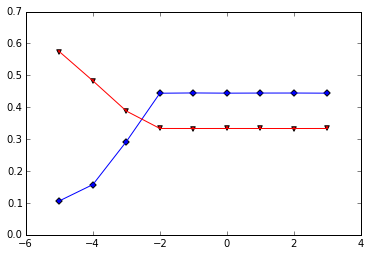

In [30]:
pogZ = []
l2 = []
for i in range(len(c)):
    clfLSVM = SVC(C = c[i], kernel='linear')
    clfLSVM.fit(X2, y2)
    pogZ.append(hinge(clfLSVM.fit(X2, y2), X2, y2))
    l2.append(L2norma(clfLSVM.coef_[0]))
matplotlib.pyplot.scatter(e, l2, s=20, c=u'b', marker=u'D')
matplotlib.pyplot.scatter(e, pogZ, s=20, c=u'r', marker=u'v')
plot(e, l2, 'b', e, pogZ, 'r')

### A.6

Na skupu `(X2,y2)` iz zadatka A.4 trenirajte tri modela SVM s različitim jezgrenim funkcijama: linearna, polinomijalna i radijalna bazna (RBF) funkcija. Varirajte parametar $C$ po vrijednostima $C\in\{10^{-2},1,10^2\}$, dok za ostale parametre (stupanj polinoma za polinomijalnu jezgru odnosno parametar $\gamma$ za jezgru RBF) koristite podrazumijevane vijednosti. Prikažite granice između klasa (i margine) na grafikonu organiziranome u polje $3x3$, gdje su stupci različite jezgre, a retci različite vrijednosti parametra $C$.

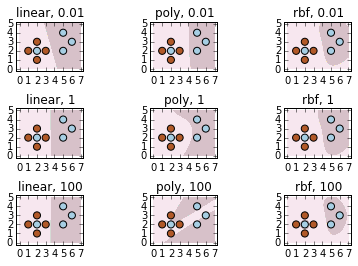

In [31]:
c = [0.01, 1, 100]
uz = linspace(1, 20, 9)
br = 1
subplots_adjust(wspace = 1, hspace=.75)
br = 1
k = ['linear', 'poly', 'rbf']
for i in c:
    for j in k:
        clf = SVC(C = i, kernel = j)
        clf.fit(X2, y2)
        subplot(3, 3, br)
        plot_problem(X2, y2, lambda x : clf.predict(x), naziv = j + ", " + str(i))
        br = br + 1

### A.7

Pored hiperparametra $C$, model SVM sa jezgrenom funkcijom RBF ima i dodatni hiperparametar $\gamma=\frac{1}{2\sigma^2}$ (preciznost). Taj parametar također određuje složenost modela: velika vrijednost za $\gamma$ znači da će RBF biti uska, primjeri će biti preslikani u prostor u kojem su (prema skalarnome produktu) međusobno vrlo različiti, što će rezultirati složenijim modelima. Obrnuto, mala vrijednost za $\gamma$ znači da će RBF biti široka, primjeri će biti međusobno sličniji, što će rezultirati jednostavnijim modelima. To ujedno znači da, ako odabremo veći $\gamma$, trebamo jače regularizirati model, tj. trebamo odabrati manji $C$, kako bismo spriječili prenaučenost. Zbog toga je potrebno zajednički optimirati hiperparametre $C$ i $\gamma$, što se tipično radi iscrpnim pretraživanjem po rešetci (engl. *grid search*). 

Definirajte funkciju `grid_search(model,X_train,X_validate,y_train,y_validate,(c1,c2),(g1,g2),error_surface=False)` koja optimizira parametre $C$ i $\gamma$ pretraživanjem po rešetci. Funkcija treba pretražiti parametre $C\in\{2^{c_1},2^{c_1+1},\dots,2^{c_2}\}$ i $\gamma\in\{2^{g_1},2^{g_1+1},\dots,2^{g_2}\}$. Funkcija treba vratiti optimalne parametre $(C^*,\gamma^*)$, tj. one koji na skupu za provjeru ostvaruju najmanju pogrešku. Dodatno, ako je `surface=True`, funkcija treba vratiti dvije matrice (tipa `ndarray`) koje pohranjuju pogreške modela (očekivanje gubitka 0-1) na skupu za učenje odnosno skupu za provjeru za svaku kombinaciju parametara $(C,\gamma)$. Svaka je matrica dimenzija $(c_2-c_1+1)\times(g_2-g_1+1)$ (retci odgovaraju različitim vrijednostima za $C$, a stupci različitim vrijednostima za $\gamma$).

Pomoću funkcije `datasets.make_classification` generirajte dva skupa podataka od $N=200$ primjera: jedan s $n=2$ dimenzije i drugi s $n=1000$ dimenzija. Primjeri neka dolaze iz dviju klasa, s time da svakoj klasi odgovaraju dvije grupe (`n_clusters_per_class=2`), kako bi problem bio nešto složeniji, tj. nelinearniji. Podijelite skup primjera na skup za učenje i skup za ispitivanje u omjeru 1:1.

In [32]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error

In [33]:
x_sl1, y_sl1 = make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=2, n_classes=2)
x_sl2, y_sl2 = make_classification(n_samples=200, n_features=1000, n_clusters_per_class=2, n_classes=2)

In [34]:
X_rest1, X_test1, y_rest1, y_test1 = cross_validation.train_test_split(x_sl1,y_sl1,test_size=0.5,random_state=42)
X_train1, X_validate1, y_train1, y_validate1 = cross_validation.train_test_split(X_rest1,y_rest1,train_size=0.75,random_state=42)

X_rest2, X_test2, y_rest2, y_test2 = cross_validation.train_test_split(x_sl2,y_sl2,test_size=0.5,random_state=42)
X_train2, X_validate2, y_train2, y_validate2 = cross_validation.train_test_split(X_rest2,y_rest2,train_size=0.75,random_state=42)

Na oba skupa optimirajte SVM s jezgrenom funkcijom RBF, u rešetci $C\in\{2^{-5},2^{-4},\dots,2^{15}\}$ i $\gamma\in\{2^{-15},2^{-14},\dots,2^{3}\}$. Prikažite površinu pogreške modela na skupu za učenje i skupu za provjeru, i to na oba skupa podataka (ukupno četiri grafikona) te ispišite optimalne kombinacije hiperparametra. Prikažite i granicu između klasa za dvodimenzijski skup. Za prikaz površine pogreške modela možete koristiti sljedeću funkciju:

In [38]:
def grid_search(model,X_train,X_validate,y_train,y_validate,c,g,error_surface=False):
    c1 = 0
    y = 0
    global zapis1
    global zapis2
    global pog1
    global pog2
    previous = 12345678912
    for i in range(len(c)):
        for j in range(len(g)):
            clf = SVC(C = c[i], kernel = model, gamma = g[j])
            clf.fit(X_train, y_train)
            current = hinge_loss(y_validate, clf.decision_function(X_validate))
            if error_surface == True:
                # gubitak 0-1
                zapis1[i][j] = np.absolute(np.subtract(clf.predict(X_validate), y_validate))
                zapis2[i][j] = np.absolute(np.subtract(clf.predict(X_train), y_train))
                # gubitak zglobnice
                pog1[i][j] = hinge_loss(y_train, clf.decision_function(X_train))
                pog2[i][j] = hinge_loss(y_validate, clf.decision_function(X_validate))
            if current < previous:
                previous = current
                c1 = c[i]
                y = g[j]
    return [c1, y]

In [39]:
global zapis1
global zapis2
global pog1
global pog2
e = linspace(-5, 15, 21)
e1 = linspace(-15, 3, 19)
c = []
gama = []
zapis1 = []
zapis2 = []
pog1 = []
pog2 = []

for i in e:
    c.append(math.pow(2, float(i)))

for i in e1:
    gama.append(math.pow(2, float(i)))

for i in range(len(c)):
    pom = []
    for j in range(len(gama)):
        pom.append(0)
    zapis1.append(pom)
    
for i in range(len(c)):
    p1 = []
    for j in range(len(gama)):
        p1.append(0)
    zapis2.append(p1)
    
for i in range(len(c)):
    p2 = []
    for j in range(len(gama)):
        p2.append(0)
    pog1.append(p2)
    
for i in range(len(c)):
    p3 = []
    for j in range(len(gama)):
        p3.append(0)
    pog2.append(p3)
    
pomocni = []
pomocni = grid_search('rbf',X_train1,X_validate1,y_train1,y_validate1,c,gama,error_surface=True)
print (pomocni)
#print (sp.array(zapis1))

[16384.0, 0.5]


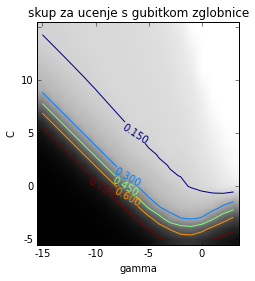

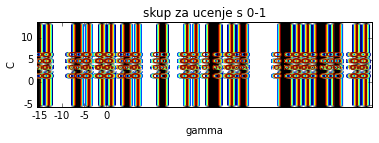

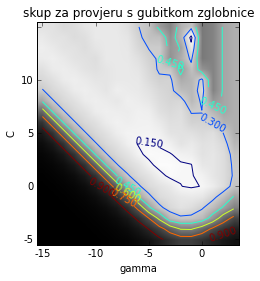

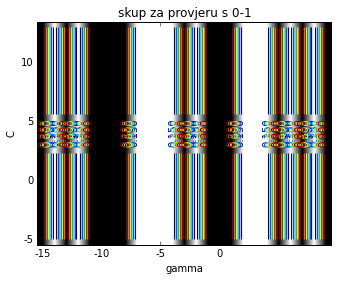

In [41]:
def plot_error_surface(err,c1,c2,g1,g2) :
    xticks(range(0,g2-g1+1,5),range(g1,g2,5)); xlabel("gamma")
    yticks(range(0,c2-c1+1,5),range(c1,c2,5)); ylabel("C")
    p = contour(err);
    imshow(1-err, interpolation='bilinear', origin='lower',cmap=cm.gray)
    clabel(p, inline=1, fontsize=10);
    show();
title("skup za ucenje s gubitkom zglobnice")
plot_error_surface(sp.array(pog1), -5, 15, -15, 3 )
title("skup za ucenje s 0-1")
plot_error_surface(sp.array(zapis2[0]), -5, 15, -15, 3 )
title("skup za provjeru s gubitkom zglobnice")
plot_error_surface(sp.array(pog2), -5, 15, -15, 3 )
title("skup za provjeru s 0-1")
plot_error_surface(sp.array(zapis1[0]), -5, 15, -15, 3 )

In [42]:
global zapis1
global zapis2
global pog1
global pog2
zapis1 = []
zapis2 = []
pog1 = []
pog2 = []

for i in range(len(c)):
    pom = []
    for j in range(len(gama)):
        pom.append(0)
    zapis1.append(pom)
    
for i in range(len(c)):
    p1 = []
    for j in range(len(gama)):
        p1.append(0)
    zapis2.append(p1)
    
for i in range(len(c)):
    p2 = []
    for j in range(len(gama)):
        p2.append(0)
    pog1.append(p2)
    
for i in range(len(c)):
    p3 = []
    for j in range(len(gama)):
        p3.append(0)
    pog2.append(p3)
    
pomocni = []
pomocni = grid_search('rbf',X_train2,X_validate2,y_train2,y_validate2,c,gama,error_surface=True)
print (pomocni)
#plot_error_surface(zapis1)

[32.0, 3.0517578125e-05]


In [43]:
'''
def plot_error_surface(err) :
    xticks(range(0,3-(-15)+1,5),range(-15,3,5)); xlabel("gamma")
    yticks(range(0,15-(-5)+1,5),range(-5,15,5)); ylabel("C")
    p = contour(err);
    imshow(1-err, interpolation='bilinear', origin='lower',cmap=cm.gray)
    clabel(p, inline=1, fontsize=10);
    show();
'''
def plot_error_surface(err,c1,c2,g1,g2) :
    xticks(range(0,g2-g1+1,5),range(g1,g2,5)); xlabel("gamma")
    yticks(range(0,c2-c1+1,5),range(c1,c2,5)); ylabel("C")
    p = contour(err);
    imshow(1-err, interpolation='bilinear', origin='lower',cmap=cm.gray)
    clabel(p, inline=1, fontsize=10);
    show();


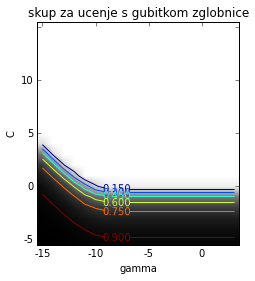

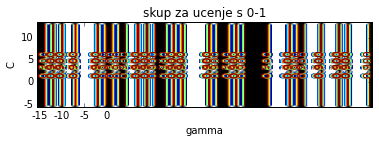

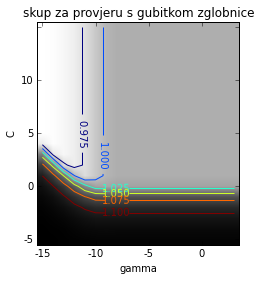

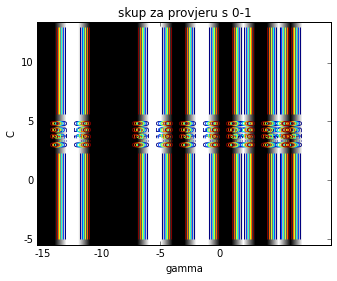

In [44]:
def plot_error_surface(err,c1,c2,g1,g2) :
    xticks(range(0,g2-g1+1,5),range(g1,g2,5)); xlabel("gamma")
    yticks(range(0,c2-c1+1,5),range(c1,c2,5)); ylabel("C")
    p = contour(err);
    imshow(1-err, interpolation='bilinear', origin='lower',cmap=cm.gray)
    clabel(p, inline=1, fontsize=10);
    show();
title("skup za ucenje s gubitkom zglobnice")
plot_error_surface(sp.array(pog1), -5, 15, -15, 3 )
title("skup za ucenje s 0-1")
plot_error_surface(sp.array(zapis2[0]), -5, 15, -15, 3 )
title("skup za provjeru s gubitkom zglobnice")
plot_error_surface(sp.array(pog2), -5, 15, -15, 3 )
title("skup za provjeru s 0-1")
plot_error_surface(sp.array(zapis1[0]), -5, 15, -15, 3 )

In [46]:
global zapis1
global zapis2
global pog1
global pog2
c = [1]
gama = [0.5]
gama2 = [1/1000]
zapis1 = []
zapis2 = []
pog1 = []
pog2 = []

for i in range(len(c)):
    pom = []
    for j in range(len(gama)):
        pom.append(0)
    zapis1.append(pom)
    
for i in range(len(c)):
    p1 = []
    for j in range(len(gama)):
        p1.append(0)
    zapis2.append(p1)
    
for i in range(len(c)):
    p2 = []
    for j in range(len(gama)):
        p2.append(0)
    pog1.append(p2)
    
for i in range(len(c)):
    p3 = []
    for j in range(len(gama)):
        p3.append(0)
    pog2.append(p3)
    
pomocni = []
pomocni = grid_search('rbf',X_train1,X_validate1,y_train1,y_validate1,c,gama,error_surface=True)
print (pomocni)
#print (sp.array(zapis1))

[1, 0.5]


In [47]:
print (pog1[0])
print(pog2[0])

[0.14622111880595823]
[0.14250775200762411]


**Q:** Razlikuje li se površina pogreške na skupu za učenje i skupu za ispitivanje? Zašto?

**Q:** U prikazu površine pogreške, koji dio površine odgovara prenaučenosti a koji podnaučenosti? Zašto?
    
**Q:** Koliko su ovi rezultati stabilni s obzirom na skup podataka? Pokažite.
    
**Q:** Kako broj dimenzija $n$ utječe na površinu pogreške odnosno na optimalne hiperparametre $(C^*, \gamma^*)$?
    
**Q:** Preporuka je da povećanje vrijednosti za $\gamma$ treba biti popraćeno smanjenjem vrijednosti za $C$. Govore li vaši rezultati u prilog toj preporuci? Obrazložite.
    
**Q:** Podrazumijevana vrijednost parametara je $C=1$ i $\gamma=1/n$. Bi li te vrijednosti bile optimalne u ovom slučaju?

Površine se razlikuju jer je model treniran na jednom skupu, a biran na drugoom. Uočljivo je da područje koje je crno je prenaučenost(velik c i gamma), a bijelo je podnaučenost. Rezultati će se sigurno mijenjati ovisno o skupu podataka. Rezultati pokazuju da je potrebno kombinirati veći gamma i manji c i obrnuto. U ovom slučaju ne bi ove vrijednosti bile optimalne.

### A.8

Model s jezgrenom funkcijom (pogotovo RBF) je nelinearan, pa je u praksi (uz propisnu optimizaciju hiperparametra) za većinu problema bolji izbor nego linearan model. Međutim, za probleme kod kojih je broj dimenzija $n$ znatno veći od broja primjera $N$, linearan model može biti jednako dobar, jer tada postaje razmjerno lako i hiperravninom razdvojiti primjere u ulaznome prostoru. S druge strane, kod problema kod kojih je broj značajki znatno manji od broja primjera, vjerojatnije je da je problem nelinearan, pa je bolje koristiti SVM s jezgrenom funkcijom. Svrha ovog zadatka jest empirijski provjeriti je li to stvarno slučaj.

Pomoću [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte dva dvoklasna skupa podataka: jedan sa $N=1000$ primjera i $n=2$ značajki te drugi sa $N=100$ primjera i $n=1000$ značajki. Svaki skup podijelite na skup za učenje i skup za provjeru u omjeru 1:1. Na skupovima za treniranje trenirajte dva modela: linearan SVM i SVM s jezgrenom funkcijom RBF. Na skupovima za provjeru napravite optimizaciju hiperparametra $C$ (za linearan model) odnosno hiperparametara $C$ i $\gamma$ (za nelinearan model), koristeći `grid_search` i raspone pretraživanja iz prethodnog zadatka (za optimizaciju samo parametra $C$ stavite `(g1,g2)=(1,1)`). Ispišite točnost obaju modela na skupu za učenje i na skupu za provjeru. Kako biste dobili robusnije procjene točnosti, eksperiment možete ponoviti više puta (npr. 5, 10 ili 30) te uprosječiti rezultate (u tom slučaju unutar petlje svaki puta nanovo generirajte oba skupa podataka).

**NB:** Ne zaboravite nanovo optimizirati hiperparametre na svakom generiranom skupu. Ako ponavljate postupak, imajte na umu da je zbog pretraživanja po rešetci on računalno zahtjevan, te da je treniranje modela s više značajki sporije.

In [68]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split

In [69]:
x_1, y_1 = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=2, n_classes=2)
x_2, y_2 = make_classification(n_samples=100, n_features=1000, n_clusters_per_class=2, n_classes=2)

X_r1, X_t1, y_r1, y_t1 = cross_validation.train_test_split(x_1,y_1,test_size=0.5,random_state=42)
X_tr1, X_val1, y_tr1, y_val1 = cross_validation.train_test_split(X_r1,y_r1,train_size=0.75,random_state=42)

X_r2, X_t2, y_r2, y_t2 = cross_validation.train_test_split(x_2,y_2,test_size=0.5,random_state=42)
X_tr2, X_val2, y_tr2, y_val2 = cross_validation.train_test_split(X_r2,y_r2,train_size=0.75,random_state=42)

In [70]:
global zapis1
global zapis2
zapis1 = []
zapis2 = []
gama1 = [1]
for i in range(len(c)):
    pom = []
    for j in range(len(gama1)):
        pom.append(0)
    zapis1.append(pom)
    
for i in range(len(c)):
    p1 = []
    for j in range(len(gama1)):
        p1.append(0)
    zapis2.append(p1)

pomocni = []
pomocni = grid_search('linear',X_tr1,X_val1,y_tr1,y_val1,c,gama1,error_surface=True)

In [71]:
br = 0
uk = 0
for i in range(len(zapis1)):
    for j in range(len(zapis1[0])):
        for k in range(len(zapis1[0][0])):
            uk = uk + 1
            if (zapis1[i][j][k] == 0):
                br = br + 1
print ("Tocnost na skupu za provjeru iznosi: ", br/uk)

br = 0
uk = 0
for i in range(len(zapis2)):
    for j in range(len(zapis2[0])):
        for k in range(len(zapis2[0][0])):
            uk = uk + 1
            if (zapis2[i][j][k] == 0):
                br = br + 1
print ("Tocnost na skupu za ucenje iznosi: ", br/uk)

Tocnost na skupu za provjeru iznosi:  0.784
Tocnost na skupu za ucenje iznosi:  0.9013333333333333


In [72]:
global zapis1
global zapis2
zapis1 = []
zapis2 = []
for i in range(len(c)):
    pom = []
    for j in range(len(gama)):
        pom.append(0)
    zapis1.append(pom)
    
for i in range(len(c)):
    p1 = []
    for j in range(len(gama)):
        p1.append(0)
    zapis2.append(p1)

pomocni = []
pomocni = grid_search('linear',X_tr2,X_val2,y_tr2,y_val2,c,gama,error_surface=True)
print("Done")

Done


In [73]:
br = 0
uk = 0
for i in range(len(zapis1)):
    for j in range(len(zapis1[0])):
        for k in range(len(zapis1[0][0])):
            uk = uk + 1
            if (zapis1[i][j][k] == 0):
                br = br + 1
print ("Tocnost na skupu za provjeru iznosi: ", br/uk)

br = 0
uk = 0
for i in range(len(zapis2)):
    for j in range(len(zapis2[0])):
        for k in range(len(zapis2[0][0])):
            uk = uk + 1
            if (zapis2[i][j][k] == 0):
                br = br + 1
print ("Tocnost na skupu za ucenje iznosi: ", br/uk)

Tocnost na skupu za provjeru iznosi:  0.5384615384615384
Tocnost na skupu za ucenje iznosi:  1.0


In [74]:
global zapis1
global zapis2
zapis1 = []
zapis2 = []
gama1 = [1]
for i in range(len(c)):
    pom = []
    for j in range(len(gama1)):
        pom.append(0)
    zapis1.append(pom)
    
for i in range(len(c)):
    p1 = []
    for j in range(len(gama1)):
        p1.append(0)
    zapis2.append(p1)

pomocni = []
pomocni = grid_search('rbf',X_tr1,X_val1,y_tr1,y_val1,c,gama1,error_surface=True)

In [75]:
br = 0
uk = 0
for i in range(len(zapis1)):
    for j in range(len(zapis1[0])):
        for k in range(len(zapis1[0][0])):
            uk = uk + 1
            if (zapis1[i][j][k] == 0):
                br = br + 1
print ("Tocnost na skupu za provjeru iznosi: ", br/uk)

br = 0
uk = 0
for i in range(len(zapis2)):
    for j in range(len(zapis2[0])):
        for k in range(len(zapis2[0][0])):
            uk = uk + 1
            if (zapis2[i][j][k] == 0):
                br = br + 1
print ("Tocnost na skupu za ucenje iznosi: ", br/uk)

Tocnost na skupu za provjeru iznosi:  0.856
Tocnost na skupu za ucenje iznosi:  0.928


In [78]:
global zapis1
global zapis2
zapis1 = []
zapis2 = []
gama1 = [1]
for i in range(len(c)):
    pom = []
    for j in range(len(gama1)):
        pom.append(0)
    zapis1.append(pom)
    
for i in range(len(c)):
    p1 = []
    for j in range(len(gama1)):
        p1.append(0)
    zapis2.append(p1)

pomocni = []
pomocni = grid_search('rbf',X_tr2,X_val2,y_tr2,y_val2,c,gama1,error_surface=True)

In [79]:
br = 0
uk = 0
for i in range(len(zapis1)):
    for j in range(len(zapis1[0])):
        for k in range(len(zapis1[0][0])):
            uk = uk + 1
            if (zapis1[i][j][k] == 0):
                br = br + 1
print ("Tocnost na skupu za provjeru iznosi: ", br/uk)

br = 0
uk = 0
for i in range(len(zapis2)):
    for j in range(len(zapis2[0])):
        for k in range(len(zapis2[0][0])):
            uk = uk + 1
            if (zapis2[i][j][k] == 0):
                br = br + 1
print ("Tocnost na skupu za ucenje iznosi: ", br/uk)

Tocnost na skupu za provjeru iznosi:  0.38461538461538464
Tocnost na skupu za ucenje iznosi:  1.0


**Q:** Jesu li rezultati očekivani? Obrazložite.
    
**Q:** Prema [Coverovom teoremu](http://en.wikipedia.org/wiki/Cover%27s_theorem), preslikavanjem problema u prostor više dimenzije povećava se vjerojatnost da je problem linearno odvojiv. Ako je to doista tako, zašto linearan model u ovom eksperimentu za slučaj kada $n\gg N$ ostvaruje manju točnost nego za slučaj kada $N\gg n$?

Rezultati svakako jesu očekivani jer će bolje generalizirati onaj s rbf kernel funkcijom nego onaj s linearnom.

### A.9

Za mnoge je modele bitno prije treniranja skalirati značajke, kako bi se spriječilo da značajke s većim numeričkim rasponima dominiraju nad onima s manjim numeričkim rasponima. To vrijedi i za SVM, kod kojega skaliranje nerijetko može znatno poboljšati rezultate. Svrha ovog zadataka jest eksperimentalo utvrditi utjecaj skaliranja značajki na točnost SVM-a.

Generirat ćemo dvoklasni skup od $N=500$ primjera s $n=2$ značajke, tako da je dimenzija $x_1$ većeg iznosa i većeg raspona od dimenzije $x_0$, te ćemo dodati jedan primjer koji vrijednošću značajke $x_1$ odskače od ostalih primjera:

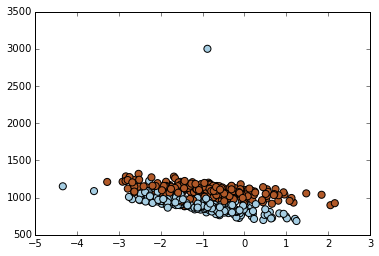

In [80]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500,n_features=2,n_classes=2,n_redundant=0,n_clusters_per_class=1)
X[:,1] = X[:,1]*100+1000
X[0,1] = 3000

plot_problem(X,y)

Proučite klase [`preprocessing.StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) i [`preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler). Proučite funkciju za iscrtavanje histograma [`hist`](http://matplotlib.org/api/pyplot_api.html). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ i to za neskalirane (izvorne) značajke, značajke skalirane standardizacijom i značajke skalirane min-max skaliranjem (ukupno šest histograma).

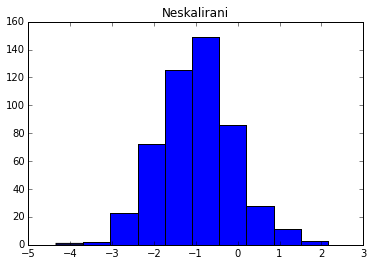

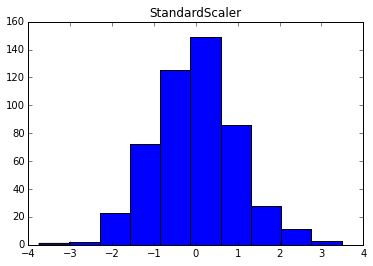

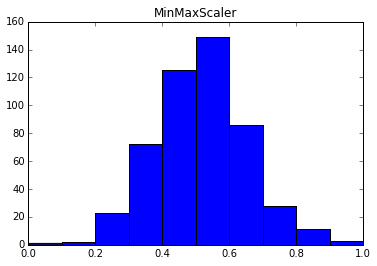

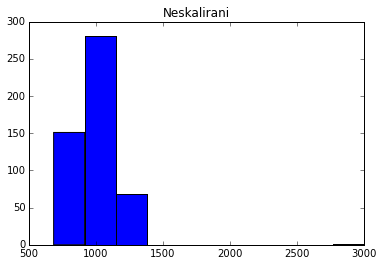

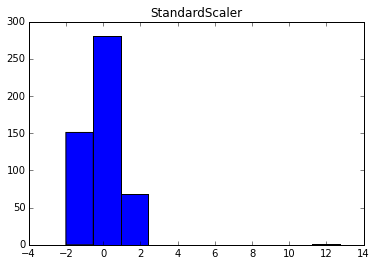

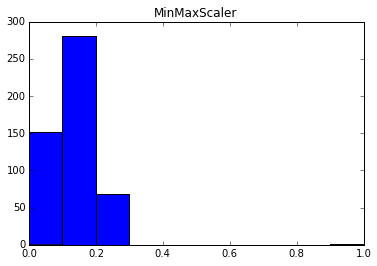

In [81]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
subplots_adjust(wspace = 1, hspace=.75)
scaler = StandardScaler().fit(X)
XScaled = scaler.transform(X) 
min_max_scaler = MinMaxScaler()
Xminmax = min_max_scaler.fit_transform(X)

for i in range(2):
    plt.hist(X[:,i])
    plt.title("Neskalirani")
    plt.show()
    
    plt.hist(XScaled[:,i])
    plt.title("StandardScaler")
    plt.show()
    
    plt.hist(Xminmax[:,i])
    plt.title("MinMaxScaler")
    plt.show()

Podijelite skup primjera na skup za učenje i skup za ispitivanje u omjeru 1:1. Trenirajte SVM s jezgrenom funkcijom RBF na skupu za učenje i ispitajte točnost modela na skupu za ispitivanje, koristeći tri varijante gornjeg skupa: neskalirane značajke, standardizirane značajke i min-max skaliranje. Koristite podrazumijevane vrijednosti za $C$ i $\gamma$. Izmjerite točnost svakog od triju modela na skupu za učenje i skupu za ispitivanje. Ponovite postupak više puta (npr. 30) te uprosječite rezultate.

**NB:** Kod skaliranja značajki treba paziti da ne dođe do "curenja informacija" sa skupa za učenje na skup za ispitivanje. Na skupu za učenje treba najprije izračunati parametre skaliranja te zatim primijeniti skaliranje (funkcija `fit_transform`), dok na skupu za ispitivanje treba samo primijeniti skaliranje s parametrima koji su dobiveni na skupu za učenje (funkcija `transform`).

**Q:** Jesu li rezultati očekivani? Obrazložite.

**Q:** Bi li bilo dobro kada bismo funkciju `fit_transform` primijenili na cijelom skupu podataka? Zašto? Bi li bilo dobro kada bismo tu funkciju primijenili zasebno na skupu za učenje i zasebno na skupu za ispitivanje? Zašto?

Rezultati jesu očekivani jer neke značajke zbilja su bile od većeg značaja nego druge pa je bilo potrebno skaliranje.
Potrebno je raditi odvojeno skaliranje jer treba najprije prilagoditi podacima za učenje, a onda samo transformirati one za testiranje

In [82]:
from sklearn.metrics import accuracy_score
accN = []
accS = []
accM = []
accN1 = []
accS1 = []
accM1 = []
for i in range(30):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state = i)
    scaler = StandardScaler()
    XScaled = scaler.fit_transform(X_train)
    XS2 = scaler.transform(X_test) 

    min_max_scaler = MinMaxScaler()
    Xminmax = min_max_scaler.fit_transform(X_train)
    Xm2 = min_max_scaler.transform(X_test)

    clf1 = SVC(kernel = 'rbf')
    clf1.fit(X_train, y_train)
    accN.append(accuracy_score(y_test, clf1.predict(X_test)))
    accN1.append(accuracy_score(y_train, clf1.predict(X_train)))

    clf2 = SVC(kernel = 'rbf')
    clf2.fit(XScaled, y_train)
    accS.append(accuracy_score(y_test, clf2.predict(XS2)))
    accS1.append(accuracy_score(y_train, clf2.predict(XScaled)))

    clf3 = SVC(kernel = 'rbf')
    clf3.fit(Xminmax, y_train)
    accM.append(accuracy_score(y_test, clf3.predict(Xm2))) 
    accM1.append(accuracy_score(y_train, clf3.predict(Xminmax))) 

print("Tocnost za neskalirane značajke na skupu za testiranje iznosi", sum(accN)/30)
print("Tocnost za neskalirane značajke na skupu za treniranje iznosi", sum(accN1)/30)
print ()
print("Tocnost za StandarScaler na skupu za testiranje iznosi", sum(accS)/30)
print("Tocnost za StandarScaler na skupu za treniranje iznosi", sum(accS1)/30)
print()
print("Tocnost za MinMaxScaler na skupu za testiranje iznosi", sum(accM)/30)
print("Tocnost za MinMaxScaler na skupu za treniranje iznosi", sum(accM1)/30)

Tocnost za neskalirane značajke na skupu za testiranje iznosi 0.838933333333
Tocnost za neskalirane značajke na skupu za treniranje iznosi 0.992533333333

Tocnost za StandarScaler na skupu za testiranje iznosi 0.946666666667
Tocnost za StandarScaler na skupu za treniranje iznosi 0.959866666667

Tocnost za MinMaxScaler na skupu za testiranje iznosi 0.856666666667
Tocnost za MinMaxScaler na skupu za treniranje iznosi 0.881466666667


### A.10

Kao i sve binarne klasifikatore, SVM je moguće primijeniti na višeklasifikacijski problem transformacijom problema u skup binarnih problema te primjenom sheme OVO ili OVR. U slučaju da je problem višeklasan, standardna implementacija [`svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) to automatski prepoznaje i primjenjuje shemu OVO. Generirajte četveroklasni skup primjera, trenirajte SVM s rezgrenom funkcijom RBF i podrazumijevanim vrijednostima za $C$ i $\gamma$ te prikažite dobivene rezultate.

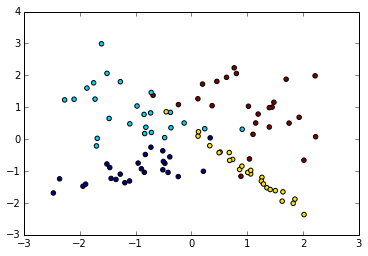

In [88]:
from sklearn.datasets import make_classification
x_sl, y_sl = make_classification(n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=4)
plt.scatter(x_sl[:, 0], x_sl[:, 1], marker='o', c=y_sl)
plt.show()

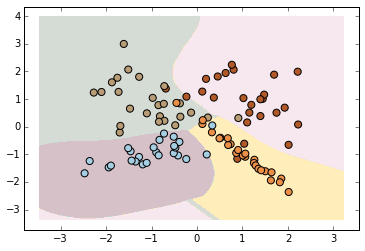

In [89]:
clf = SVC(kernel = 'rbf')
clf.fit(x_sl, y_sl)
plot_problem(x_sl, y_sl, lambda x : clf.predict(x))

**Q:** Koliko je binarnih klasifikatora trenirano u ovom slučaju?

**Q:** Što su prednosti a što nedostatci sheme OVO nad shemom OVR? Što mislite, zašto je shema OVO bolji izbor za SVM od sheme OVR?

Četiri binarna klasifikatora. 

### A.11 (bonus)

Preuzmite [`Glass Identification Data Set`](https://archive.ics.uci.edu/ml/datasets/Glass+Identification), koji opisuje rezultate kemijske analize 214 stakala. Riječ je o klasifikacijskom problemu sa šest klase: na temelju 9 kemijskih značajki stakla potrebno je, u svrhu forenzičke analize, odrediti o kojoj se od šest vrsta stakla radi. Skup podataka možete učitati na sljedeći način:

In [93]:
def gridSearch(model,X_train,X_validate,y_train,y_validate,c,g,error_surface=False):
    c1 = 0
    y = 0
    global zapis1
    global zapis2
    previous = 12345678912
    for i in range(len(c)):
        for j in range(len(g)):
            clf = SVC(C = c[i], kernel = model, gamma = g[j])
            clf.fit(X_train, y_train)
            #current = hinge_loss(y_validate, clf.decision_function(X_validate)))
            current = mean_squared_error(y_validate, clf.predict(X_validate))
            #print(current)
            if error_surface == True:
                # gubitak 0-1
                zapis1[i][j] = np.absolute(np.subtract(clf.predict(X_validate), y_validate))
                zapis2[i][j] = np.absolute(np.subtract(clf.predict(X_train), y_train))
            if current < previous:
                previous = current
                c1 = c[i]
                y = g[j]
    return [c1, y]

In [94]:
from sklearn.preprocessing import StandardScaler
data = sp.loadtxt("C:/Users/Matea/Desktop/glass.data", delimiter=",")
glass_X, glass_y = data[:,1:10], data[:,10]

Skup zatim podijelite na skup za učenje i skup za ispitivanje u omjeru 2:1, kako slijedi:

In [95]:
from sklearn import cross_validation
X_rest, X_test, y_rest, y_test = cross_validation.train_test_split(glass_X,glass_y,train_size=2.0/3,random_state=42)
scaler = StandardScaler()
XScaled = scaler.fit_transform(X_rest)
XS2 = scaler.transform(X_test) 
X_train, X_validate, y_train, y_validate = cross_validation.train_test_split(XScaled,y_rest,train_size = 0.75,random_state=42)
print (X_train.shape, X_test.shape, X_validate.shape)

(106, 9) (72, 9) (36, 9)


In [96]:
from sklearn.metrics import accuracy_score
global zapis1
global zapis2
e = linspace(-5, 15, 21)
e1 = linspace(-15, 3, 19)
c = []
gama = []
zapis1 = []
zapis2 = []

for i in e:
    c.append(math.pow(2, float(i)))

for i in e1:
    gama.append(math.pow(2, float(i)))

for i in range(len(c)):
    pom = []
    for j in range(len(gama)):
        pom.append(0)
    zapis1.append(pom)
    
for i in range(len(c)):
    p1 = []
    for j in range(len(gama)):
        p1.append(0)
    zapis2.append(p1)
acc1 = 0
acc2 = 0

pomocni = []
pomocni = gridSearch('linear',X_train,X_validate,y_train,y_validate,c,gama,error_surface=False)
print (pomocni)


[2.0, 3.0517578125e-05]


In [87]:
clf1 = SVC (kernel = 'linear', C = pomocni[0], gamma = pomocni[1])
clf1.fit(XScaled, y_rest)
print ("Tocnost na skupu za ispitivanje: ",accuracy_score(y_test, clf1.predict(XS2)))
print ("Tocnost na skupu za ucenje: ",accuracy_score(y_rest, clf1.predict(XScaled)))

Tocnost na skupu za ispitivanje:  0.652777777778
Tocnost na skupu za ucenje:  0.718309859155


In [97]:
from sklearn.metrics import accuracy_score
global zapis1
global zapis2
e = linspace(-5, 15, 21)
e1 = linspace(-15, 3, 19)
c = []
gama = []
zapis1 = []
zapis2 = []

for i in e:
    c.append(math.pow(2, float(i)))

for i in e1:
    gama.append(math.pow(2, float(i)))

for i in range(len(c)):
    pom = []
    for j in range(len(gama)):
        pom.append(0)
    zapis1.append(pom)
    
for i in range(len(c)):
    p1 = []
    for j in range(len(gama)):
        p1.append(0)
    zapis2.append(p1)
acc1 = 0
acc2 = 0

pomocni1 = []
pomocni1 = gridSearch('rbf',X_train,X_validate,y_train,y_validate,c,gama,error_surface=False)
print (pomocni1)

clf2 = SVC (kernel = 'rbf', C = pomocni1[0], gamma = pomocni1[1])
clf2.fit(XScaled, y_rest)
print ("Tocnost na skupu za ispitivanje: ",accuracy_score(y_test, clf2.predict(XS2)))
print ("Tocnost na skupu za ucenje: ",accuracy_score(y_rest, clf2.predict(XScaled)))
print (clf2.support_)

[128.0, 0.00390625]
Tocnost na skupu za ispitivanje:  0.722222222222
Tocnost na skupu za ucenje:  0.781690140845
[  0   1   5  13  17  19  25  27  28  31  32  36  40  41  47  48  52  58
  62  68  73  75  80  82  90  91  92  95 102 103 112 113 118 121 122 134
 138   2   3   4   6  11  12  14  15  16  18  22  23  29  30  37  42  44
  46  49  55  59  61  65  69  74  76  81  84  85  89  97  99 111 117 124
 126 127 128 131 136 137 139 141  10  20  39  43  45  50  54  64  72 114
 119 123 125   7  56  70  78  96 106 108  34  51  93 100 140  26  33  63
  79 101 115 116 120 135]


Na skupu za učenje trenirajte dva modela: SVM s linearnom jezgrenom funkcijom i SVM s jezgrenom funkcijom RBF. Optimizaciju hiperparametara načinite pretraživanjem po rešetci na skupu za provjeru, koji ćete dobiti dodatnom podjelom skupa za učenje, dok točnost modela ispitajte na skupu za ispitivanje. Napravite standardizaciju značajki uvažavajući spoznaje iz zadatka A.9. Ispišite točnost obaju modela na skupu za učenje i na skupu za ispitivanje.

**Q:** Možete li reći koliko značajki ima vaš najbolji model (u prostoru značajki)?

**Q:** Koliko potpornih vektora ima vaš najbolji model i koliki je to udio od ukupnog broja primjera?

**Q:** Usporedite točnost modela na skupu za učenje i na skupu za ispitivanje. Što možete zaključiti na temelju te usporedbe?

**Q:** Usporedite točnost najboljeg linearnog i najboljeg nelinearnog modela. Što možete zaključiti na temelju te usporedbe?

**Q:** Usporedite točnost najboljeg modela s točnoću linearne regresije (zadatak C.11 iz druge vježbe). Što možete zaključiti na temelju te usporedbe?

**Q:** Na koliko je primjera naučen klasifikator koji ste u konačnici ispitali? Vidite li problem u tome što nisu iskorišteni svi primjeri? Kako biste riješili taj problem?

Model ima jako puno potpornih vektora i uočljivo je da je točnost veća na skupu za treniranje. Također, nelinarni model bolju točnost daje. Klasifikator je naučen na 106 primjera i očito je da klasifikacija nije baš najbolja pa bi bilo zgodno povećati broj primjera ili primjeniti neku od poznatih metoda za podjelu skupova kako bi se poboljšala klasifikacija.

## B. Neparametarski modeli

<div style="color:red">TBD</div>

## C. Vrednovanje klasifikatora

<div style="color:red">TBD</div>

## D. Grupiranje

<div style="color:red">TBD</div>